In [12]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:

sns.set_style("whitegrid")

# ⚠️ Adjust this to your tracking URI if needed
mlflow.set_tracking_uri("file:///Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Moons/mlruns")

# If you already have `all_runs` in the notebook, you can skip this cell.
all_runs = mlflow.search_runs(search_all_experiments=True)
print(f"Found {len(all_runs)} runs")
print(all_runs.columns)



Found 1568 runs
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_loss', 'metrics.train_loss', 'metrics.val_f1',
       'metrics.recall', 'metrics.precision', 'metrics.f1_score',
       'metrics.accuracy', 'params.epochs', 'params.batch_size',
       'params.alpha', 'params.val_size', 'params.dataset',
       'params.imbalance_ratio', 'params.gamma', 'params.num_samples',
       'params.noise', 'params.num_layer', 'params.learning_rate',
       'params.test_size', 'params.config_version', 'params.hidden_size',
       'params.loss_function', 'params.ce_weight', 'tags.mlflow.user',
       'tags.mlflow.source.name', 'tags.mlflow.source.git.commit',
       'tags.mlflow.source.type', 'tags.mlflow.runName'],
      dtype='object')


In [14]:
print(all_runs.columns)

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_loss', 'metrics.train_loss', 'metrics.val_f1',
       'metrics.recall', 'metrics.precision', 'metrics.f1_score',
       'metrics.accuracy', 'params.epochs', 'params.batch_size',
       'params.alpha', 'params.val_size', 'params.dataset',
       'params.imbalance_ratio', 'params.gamma', 'params.num_samples',
       'params.noise', 'params.num_layer', 'params.learning_rate',
       'params.test_size', 'params.config_version', 'params.hidden_size',
       'params.loss_function', 'params.ce_weight', 'tags.mlflow.user',
       'tags.mlflow.source.name', 'tags.mlflow.source.git.commit',
       'tags.mlflow.source.type', 'tags.mlflow.runName'],
      dtype='object')


In [15]:
print(all_runs.describe())
print(all_runs.columns)

       metrics.val_loss  metrics.train_loss  metrics.val_f1  metrics.recall  \
count      1.482000e+03        1.482000e+03     1568.000000     1568.000000   
mean       6.367034e-01        2.323621e-01        0.540184        0.709196   
std        3.358451e+00        5.207975e-01        0.296534        0.323562   
min        9.287828e-07        7.839919e-08        0.000000        0.000000   
25%        1.178619e-02        4.187711e-03        0.372178        0.520000   
50%        5.122024e-02        3.130739e-02        0.548771        0.840000   
75%        1.964748e-01        1.293864e-01        0.800000        0.960000   
max        6.649596e+01        2.813605e+00        1.000000        1.000000   

       metrics.precision  metrics.f1_score  metrics.accuracy  
count        1568.000000       1568.000000       1568.000000  
mean            0.535437          0.569398          0.848792  
std             0.321698          0.302120          0.173467  
min             0.000000          0.

In [16]:
#Find best F1 Score model for dataset with noise 0.1 and imbalance_ratio 0.5 for each loss_fn also return the parameters for loss function aswell. Means alpha and gamma for focal and weight for wce
# Get unique noise and imbalance_ratio values
noises = all_runs['params.noise'].unique()
imbalance_ratios = all_runs['params.imbalance_ratio'].unique()

# Create results list
all_results = []

# Iterate through all combinations
for noise in noises:
    for imbalance_ratio in imbalance_ratios:
        filtered_runs = all_runs[
            (all_runs['params.noise'] == noise) &
            (all_runs['params.imbalance_ratio'] == imbalance_ratio)
        ]

        if len(filtered_runs) == 0:
            continue

        # Group by loss function and find best F1 score for each
        best_models = filtered_runs.groupby('params.loss_function').apply(
            lambda group: group.loc[group['metrics.f1_score'].idxmax()]
        ).reset_index(drop=True)

        # Extract relevant information
        for idx, row in best_models.iterrows():
            loss_fn = row['params.loss_function']

            result = {
                'noise': noise,
                'imbalance_ratio': imbalance_ratio,
                'loss_fn': loss_fn,
                'f1_score': row['metrics.f1_score'],
                'run_id': row['run_id']
            }

            # Extract loss-specific parameters
            if loss_fn == 'focal':
                result['alpha'] = row['params.alpha']
                result['gamma'] = row['params.gamma']
            elif loss_fn == 'wce':
                result['weight'] = row['params.ce_weight']

            # Add all metrics columns
            metrics_cols = [col for col in row.index if col.startswith('metrics.')]
            for metric_col in metrics_cols:
                metric_name = metric_col.replace('metrics.', '')
                result[metric_name] = row[metric_col]

            all_results.append(result)

results_df = pd.DataFrame(all_results)
print(results_df)

   noise imbalance_ratio loss_fn  f1_score                            run_id  \
0    0.9             0.5      ce  0.642998  3d509050b1074d10a20b98cfd6f786ba   
1    0.9             0.5   focal  0.658703  76cf647b314e46ce965203c17d7e8714   
2    0.9             0.5     wce  0.628225  7a1b1a07ed594d209e190ba5743378d2   
3    0.9            0.25      ce  0.484305  6fa2c2d93a1a4671b25270ba2aa7350a   
4    0.9            0.25   focal  0.575080  a2a50b7dd27a4fe3b24fb36021c6bc28   
..   ...             ...     ...       ...                               ...   
79   0.1             0.1   focal  0.989899  f899f08949274e678c2b2e61a1047a38   
80   0.1             0.1     wce  0.989899  ae7cbf9a06d1422495a241d7b46fa61e   
81   0.1            0.01      ce  0.888889  7743456a919f4230a8e45e1d27147ba7   
82   0.1            0.01   focal  0.888889  2bbf9c4618024ddd8af66030162becc6   
83   0.1            0.01     wce  1.000000  cf6e102ced834d5f8f9210ac81c573cd   

    val_loss    train_loss    val_f1  r

/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_33748/1815785922.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby('params.loss_function').apply(
/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_33748/1815785922.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby('params.loss_function').apply(
/var/folders/pq/7tww9h2961b0

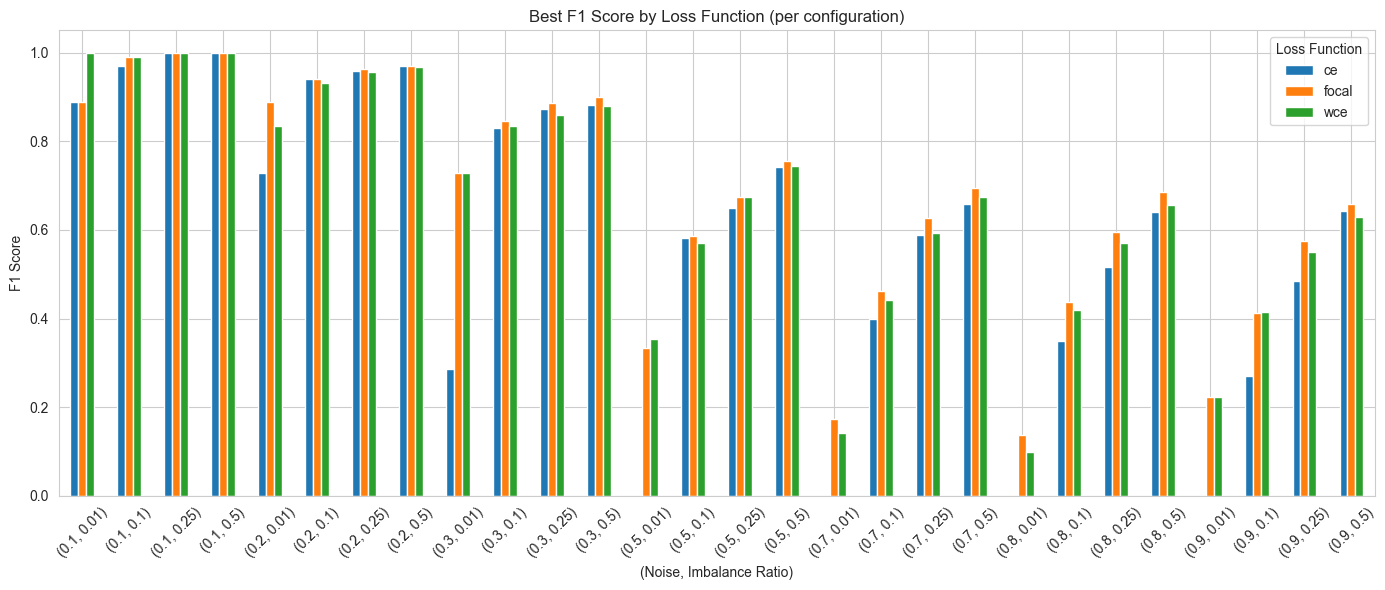

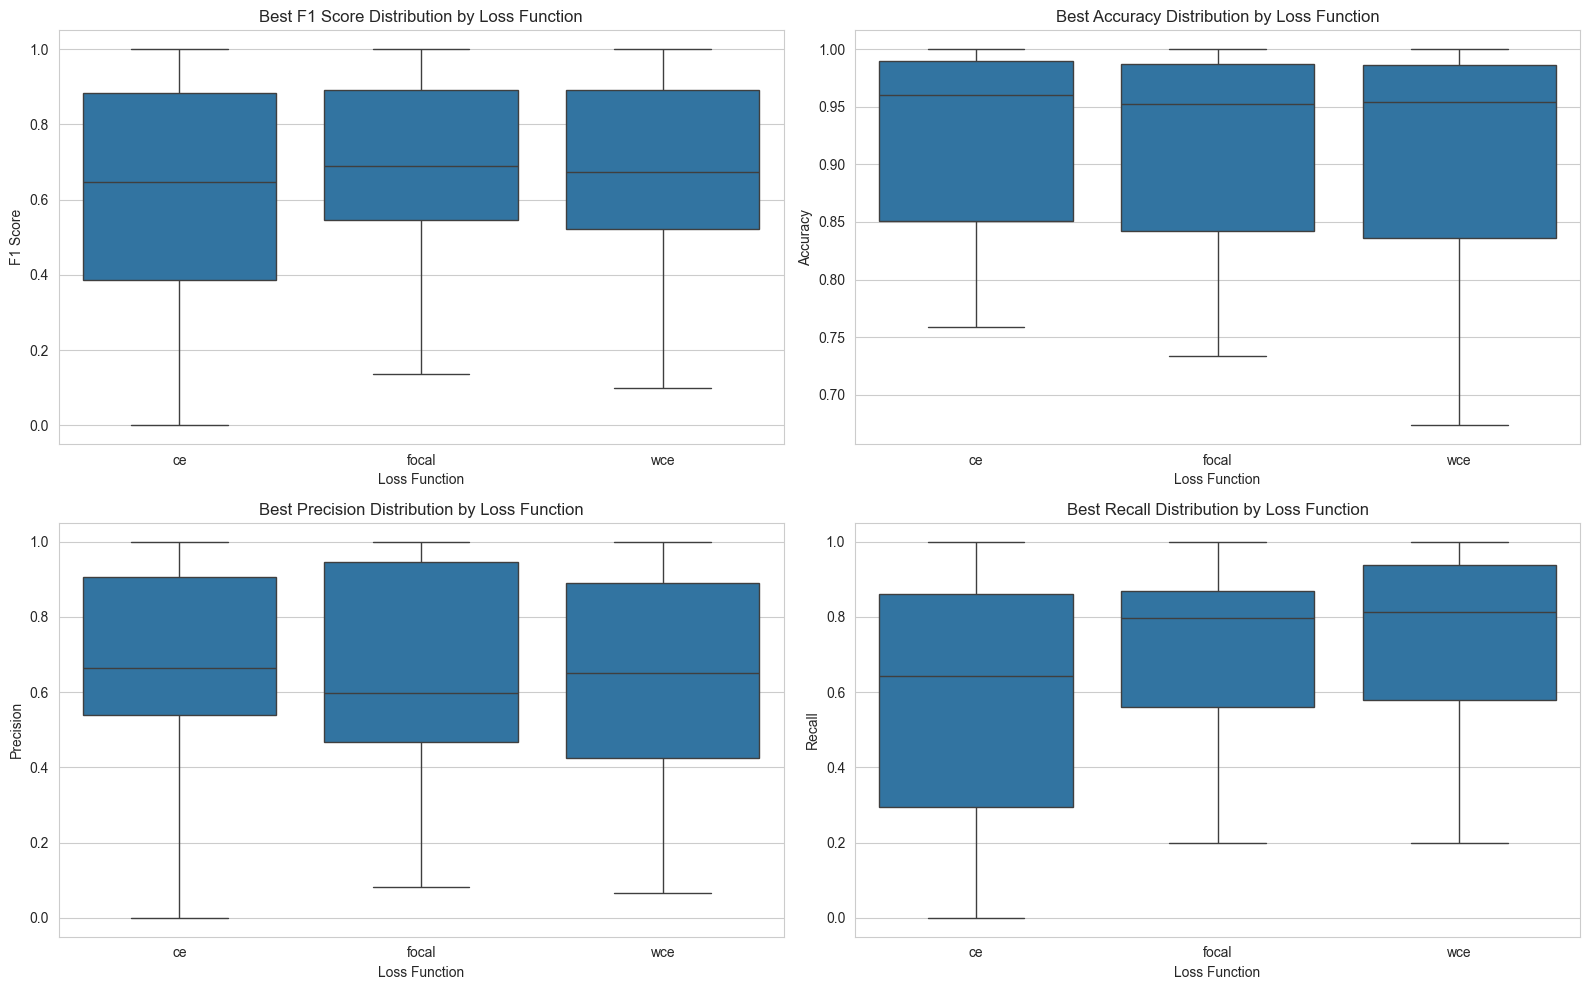

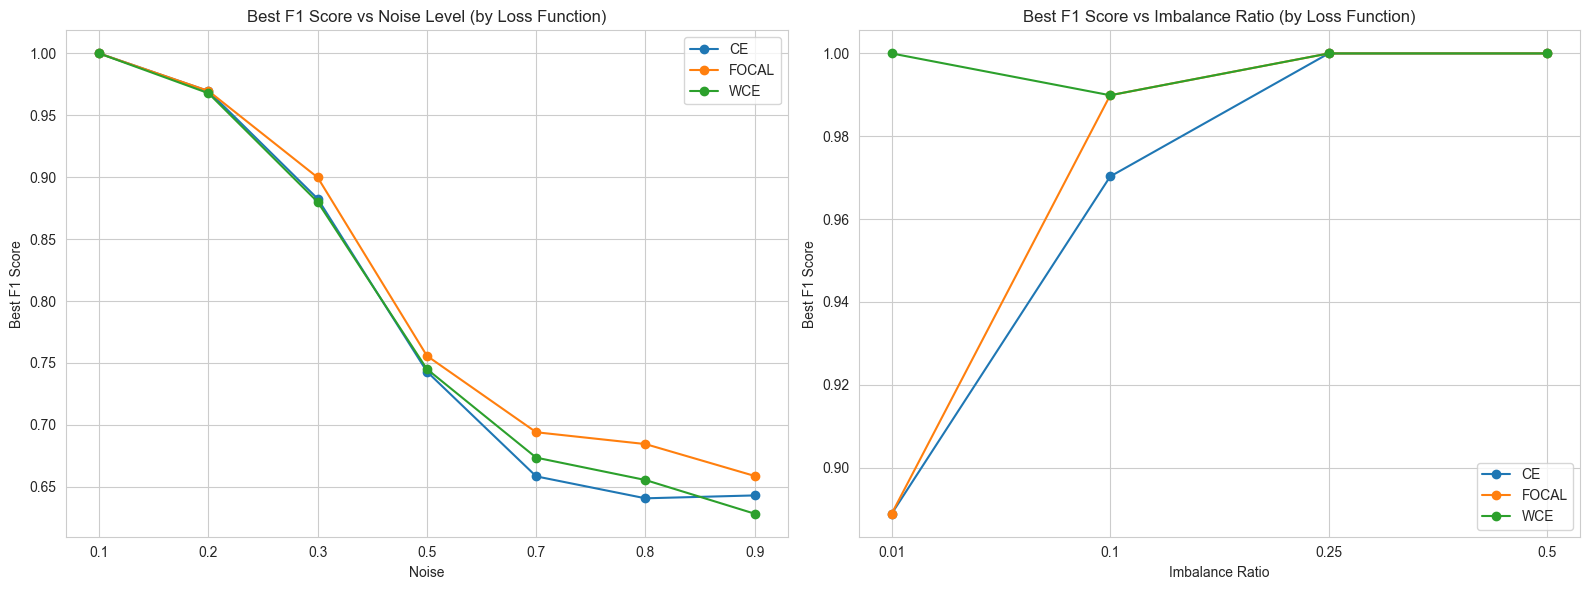

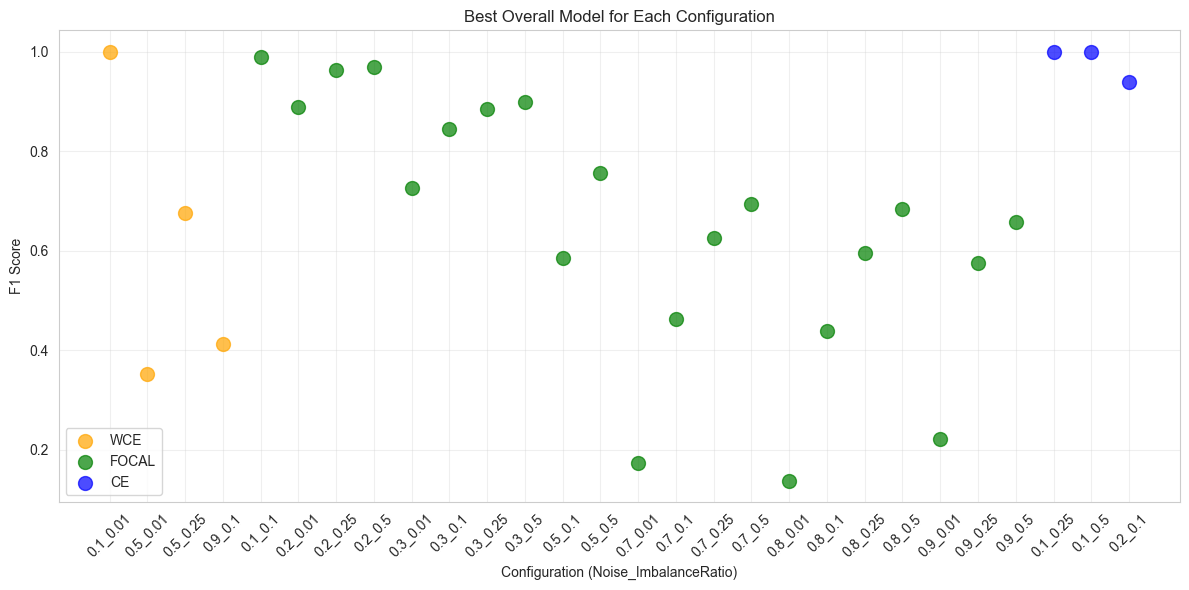

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 1. F1 Score comparison across loss functions for each noise-imbalance combination
fig, ax = plt.subplots(figsize=(14, 6))
pivot_f1 = results_df.pivot_table(
    values='f1_score',
    index=['noise', 'imbalance_ratio'],
    columns='loss_fn',
    aggfunc='first'
)
pivot_f1.plot(kind='bar', ax=ax)
ax.set_title('Best F1 Score by Loss Function (per configuration)')
ax.set_xlabel('(Noise, Imbalance Ratio)')
ax.set_ylabel('F1 Score')
ax.legend(title='Loss Function')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 2. Box plot comparing metrics across loss functions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_to_plot = ['f1_score', 'accuracy', 'precision', 'recall']

for i, metric in enumerate(metrics_to_plot):
    if metric in results_df.columns:
        ax = axes[i // 2, i % 2]
        sns.boxplot(data=results_df, x='loss_fn', y=metric, ax=ax)
        ax.set_title(f'Best {metric.replace("_", " ").title()} Distribution by Loss Function')
        ax.set_xlabel('Loss Function')
        ax.set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()

# 3. Line plot showing best F1 score trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Noise (for each loss function, show best F1 at each noise level)
for loss_fn in results_df['loss_fn'].unique():
    loss_data = results_df[results_df['loss_fn'] == loss_fn]
    grouped = loss_data.groupby('noise')['f1_score'].max()  # Best F1 at each noise level
    axes[0].plot(grouped.index, grouped.values, marker='o', label=loss_fn.upper())

axes[0].set_title('Best F1 Score vs Noise Level (by Loss Function)')
axes[0].set_xlabel('Noise')
axes[0].set_ylabel('Best F1 Score')
axes[0].legend()
axes[0].grid(True)

# F1 vs Imbalance Ratio
for loss_fn in results_df['loss_fn'].unique():
    loss_data = results_df[results_df['loss_fn'] == loss_fn]
    grouped = loss_data.groupby('imbalance_ratio')['f1_score'].max()  # Best F1 at each imbalance ratio
    axes[1].plot(grouped.index, grouped.values, marker='o', label=loss_fn.upper())

axes[1].set_title('Best F1 Score vs Imbalance Ratio (by Loss Function)')
axes[1].set_xlabel('Imbalance Ratio')
axes[1].set_ylabel('Best F1 Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 4. Best overall model for each noise-imbalance combination
fig, ax = plt.subplots(figsize=(12, 6))
results_df['config'] = results_df['noise'].astype(str) + '_' + results_df['imbalance_ratio'].astype(str)
best_per_config = results_df.loc[results_df.groupby('config')['f1_score'].idxmax()]

colors = {'ce': 'blue', 'wce': 'orange', 'focal': 'green'}
for loss_fn in best_per_config['loss_fn'].unique():
    data = best_per_config[best_per_config['loss_fn'] == loss_fn]
    ax.scatter(data['config'], data['f1_score'], label=loss_fn.upper(),
               color=colors.get(loss_fn, 'gray'), s=100, alpha=0.7)

ax.set_title('Best Overall Model for Each Configuration')
ax.set_xlabel('Configuration (Noise_ImbalanceRatio)')
ax.set_ylabel('F1 Score')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
def get_best_runs_per_config(all_runs: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    df = all_runs.copy()

    df = df[df['params.num_layer'].astype(int) == num_layer]

    df['noise'] = df['params.noise'].astype(float)
    df['imbalance_ratio'] = df['params.imbalance_ratio'].astype(float)
    df['loss_function'] = df['params.loss_function']

    group_cols = ['noise', 'imbalance_ratio', 'loss_function']

    best_idx = df.groupby(group_cols)['metrics.val_f1'].idxmax()
    best = df.loc[best_idx].reset_index(drop=True)

    return best

best_small = get_best_runs_per_config(all_runs, num_layer=2)
best_big   = get_best_runs_per_config(all_runs, num_layer=4)

display(best_small[['run_id', 'noise', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])
display(best_big[['run_id', 'noise', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])


,run_id,noise,imbalance_ratio,loss_function,metrics.val_f1
0,cdf37eb158c7410b9ed4ab31361cdb7b,0.1,0.01,ce,0.500000
1,765c3714a5474f9b9b1926d43efde152,0.1,0.01,focal,0.800000
2,8bace7794c71453bbf072767973f1428,0.1,0.01,wce,0.500000
3,6687d4f71ece4be3abd83d263232c8a5,0.1,0.10,ce,0.958333
4,5e49a1797c614e9da5e99d8fa890861c,0.1,0.10,focal,1.000000
...,...,...,...,...,...
79,a2a50b7dd27a4fe3b24fb36021c6bc28,0.9,0.25,focal,0.537931
80,4b7969ff6037495ba8d255b8ce5aa99a,0.9,0.25,wce,0.507614
81,8d00e45bb03047c6ac0f7e739d8ae595,0.9,0.50,ce,0.540000
82,46ea0b488a8143ec8b005c07cdfd003c,0.9,0.50,focal,0.673333


,run_id,noise,imbalance_ratio,loss_function,metrics.val_f1
0,7743456a919f4230a8e45e1d27147ba7,0.1,0.01,ce,0.800000
1,d92998bd8fcf4091a4bf8d1c1990aac0,0.1,0.01,focal,0.800000
2,22e372fdebbd4983b6a1922d0288d52b,0.1,0.01,wce,0.800000
3,2ff700ba2ae048bfbe79d46acc5b6759,0.1,0.10,ce,1.000000
4,8e65db4374b34b078760a3978829615a,0.1,0.10,focal,1.000000
...,...,...,...,...,...
79,89dc94db7a1045349a91af241442ae5d,0.9,0.25,focal,0.550336
80,5d3a7d7da5794092b50f912a493897aa,0.9,0.25,wce,0.545455
81,3d509050b1074d10a20b98cfd6f786ba,0.9,0.50,ce,0.473118
82,5fe62a090dd348bb92f1e5d591126b57,0.9,0.50,focal,0.653968


In [19]:
client = MlflowClient()

def fetch_val_f1_history(best_df: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    rows = []

    for _, row in best_df.iterrows():
        run_id = row['run_id']
        hist = client.get_metric_history(run_id, "val_f1")

        for m in hist:
            rows.append({
                "step": m.step,
                "val_f1": m.value,
                "noise": float(row['noise']),
                "imbalance_ratio": float(row['imbalance_ratio']),
                "loss_function": row['loss_function'],
                "num_layer": num_layer,
            })

    return pd.DataFrame(rows)

hist_small = fetch_val_f1_history(best_small, 2)
hist_big   = fetch_val_f1_history(best_big, 4)


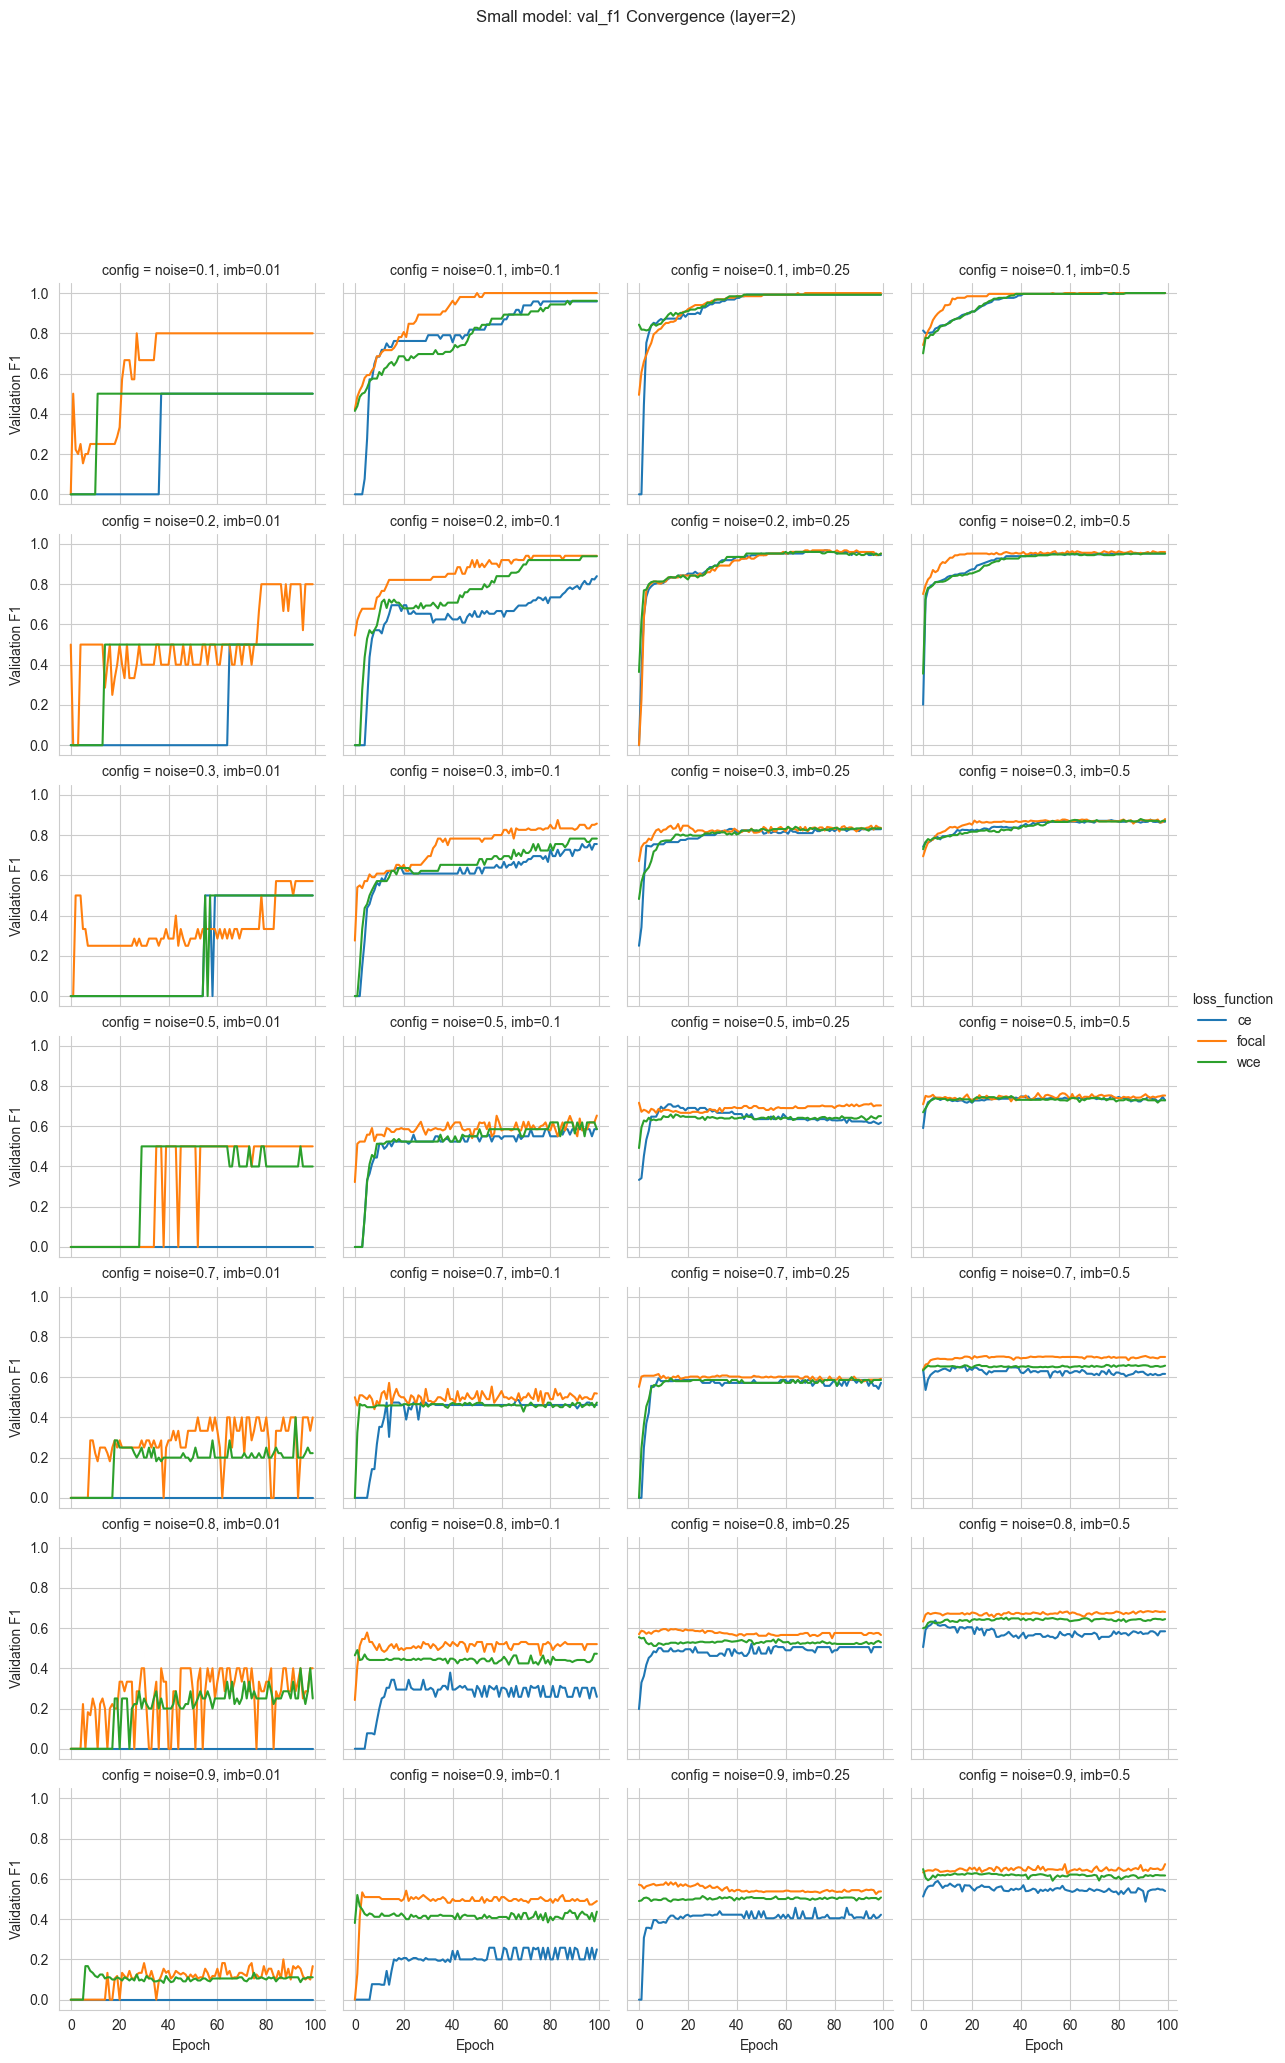

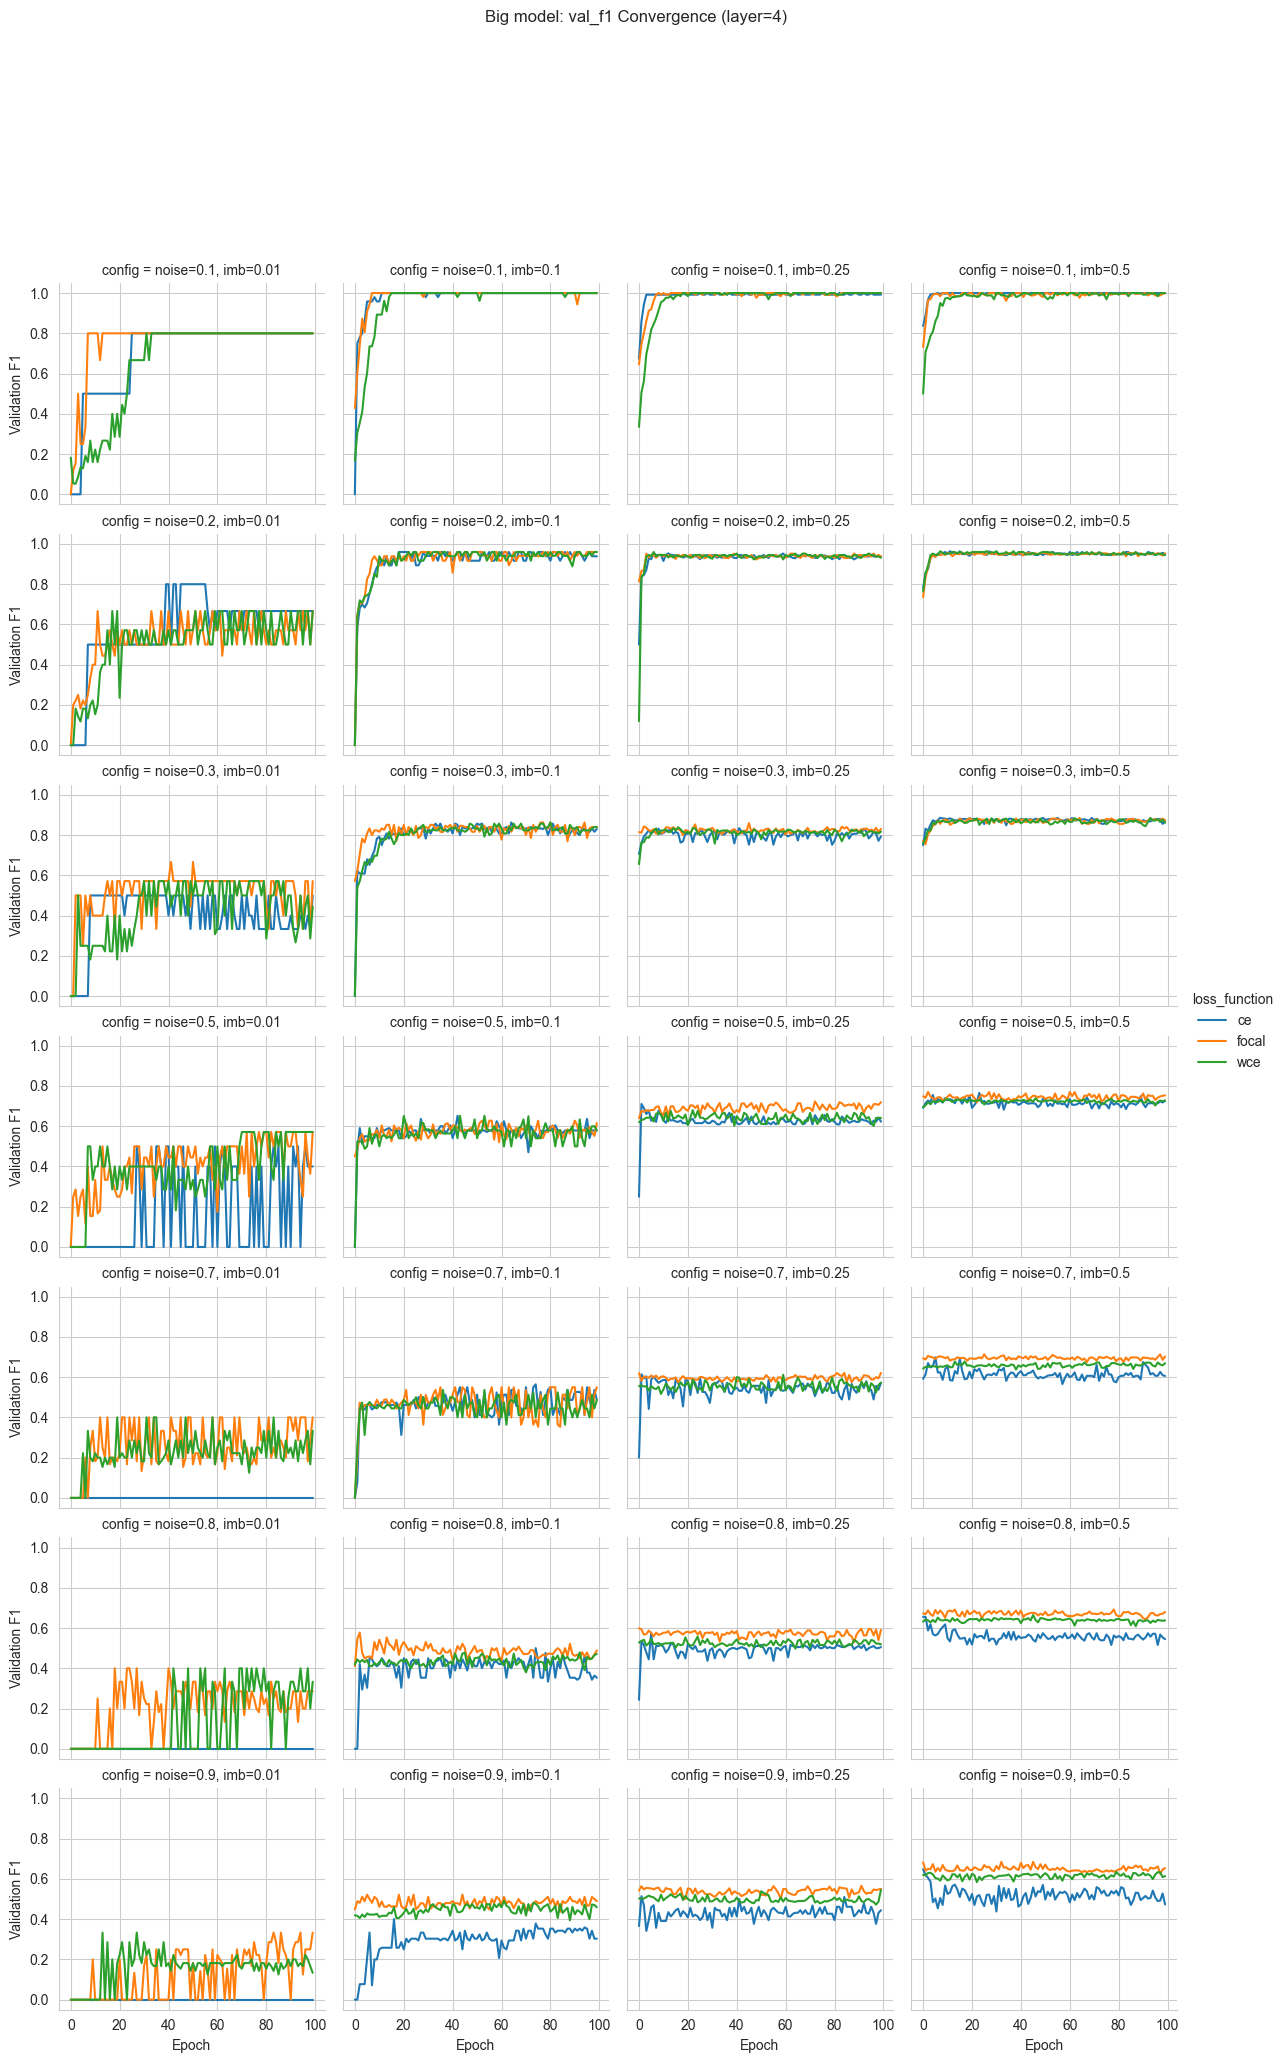

In [28]:
def plot_convergence_grid(hist_df: pd.DataFrame, num_layer: int, title_prefix: str):
    if hist_df.empty:
        print(f"No history found for {num_layer} layers")
        return

    df = hist_df.copy()
    df['config'] = df.apply(lambda r: f"noise={r['noise']}, imb={r['imbalance_ratio']}", axis=1)

    g = sns.relplot(
        data=df,
        x="step",
        y="val_f1",
        hue="loss_function",
        kind="line",
        col="config",
        col_wrap=4,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
    )
    g.set_axis_labels("Epoch", "Validation F1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{title_prefix}: val_f1 Convergence (layer={num_layer})")
    plt.show()

plot_convergence_grid(hist_small, 2, "Small model")
plot_convergence_grid(hist_big, 4, "Big model")


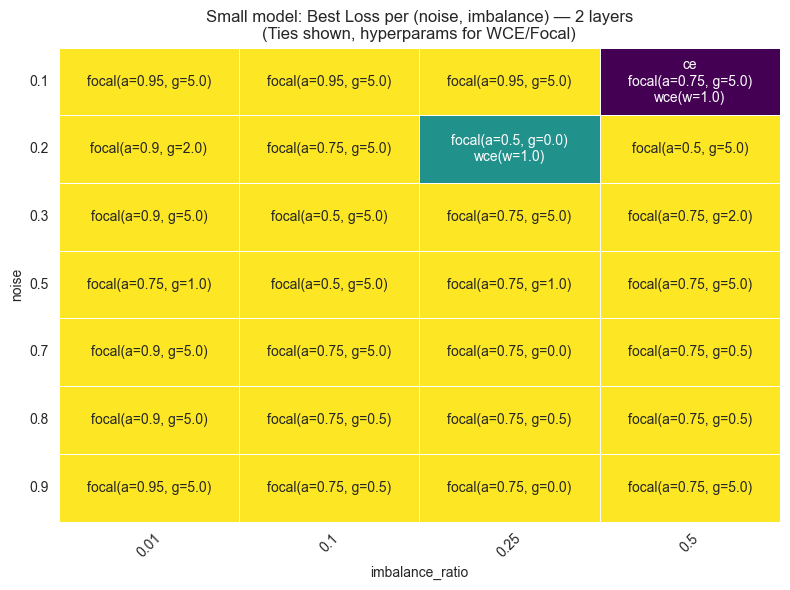

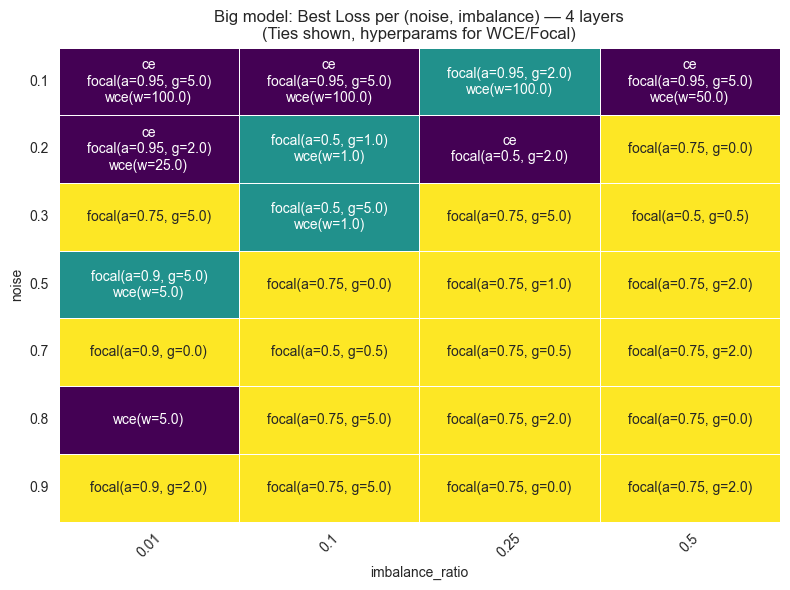

In [29]:
losses = ["ce", "wce", "focal"]  # desired order for coloring

def plot_best_loss_heatmap(best_df: pd.DataFrame, num_layer: int, title_prefix: str):
    df = best_df.copy()

    df['noise'] = df['noise'].astype(float)
    df['imbalance_ratio'] = df['imbalance_ratio'].astype(float)

    # --------------------------------------------------
    # 1) Collect best loss/es per (noise, imbalance),
    #    including hyperparams for wce / focal
    # --------------------------------------------------
    grouped = df.groupby(['noise', 'imbalance_ratio'])
    rows = []

    for (noise, imb), g in grouped:
        max_val = g['metrics.val_f1'].max()
        best_rows = g[g['metrics.val_f1'] == max_val]

        labels = []
        base_loss_indices = []

        for _, r in best_rows.iterrows():
            loss_fn = r['loss_function']

            # Base index for coloring
            if loss_fn in losses:
                base_loss_indices.append(losses.index(loss_fn))

            # Build label with hyperparams when relevant
            if loss_fn == "wce":
                ce_w = r.get('params.ce_weight', None)
                label = f"wce(w={ce_w})" if ce_w is not None else "wce"
            elif loss_fn == "focal":
                alpha = r.get('params.alpha', None)
                gamma = r.get('params.gamma', None)
                if alpha is not None and gamma is not None:
                    label = f"focal(a={alpha}, g={gamma})"
                else:
                    label = "focal"
            else:
                # plain CE or anything else
                label = loss_fn

            labels.append(label)

        # Text in the cell: one line per winner
        annot = "\n".join(labels)

        # Color: mean of base loss indices (handles ties)
        if base_loss_indices:
            mean_code = np.mean(base_loss_indices)
        else:
            mean_code = 0.0  # fallback

        rows.append({
            "noise": noise,
            "imbalance_ratio": imb,
            "annot": annot,
            "loss_code": mean_code,
        })

    df_best = pd.DataFrame(rows)

    # --------------------------------------------------
    # 2) Pivot to matrices
    # --------------------------------------------------
    table = df_best.pivot(index='noise', columns='imbalance_ratio', values='loss_code')
    annot_table = df_best.pivot(index='noise', columns='imbalance_ratio', values='annot')

    # --------------------------------------------------
    # 3) Plot (no colorbar)
    # --------------------------------------------------
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        table,
        annot=annot_table,
        fmt="",
        cmap='viridis',
        linewidths=0.5,
        cbar=False
    )

    ax.set_title(f"{title_prefix}: Best Loss per (noise, imbalance) — {num_layer} layers\n(Ties shown, hyperparams for WCE/Focal)")
    ax.set_xlabel("imbalance_ratio")
    ax.set_ylabel("noise")

    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_best_loss_heatmap(best_small, 2, "Small model")
plot_best_loss_heatmap(best_big,   4, "Big model")
